In [1]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns
import tqdm

import article

In [2]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

#### helper functions

In [3]:
def convert_seg_error_rate_pct(df):
    df.avg_segment_error_rate = df.avg_segment_error_rate * 100
    return df

In [4]:
def add_species(df, species):
    df['species'] = species
    return df

In [5]:
def filter_cleanups(df, cleanups):
    return df[df.cleanup.isin(cleanups)]

In [6]:
def clean_df(df, species, cleanups):
    df = convert_seg_error_rate_pct(df)
    df = add_species(df, species)
    df = filter_cleanups(df, cleanups)
    return df

### Figure

not using `sns.set_` because the `plt.annotate` arrows don't show up

In [7]:
# sns.set_style("white")
# sns.set_context("paper")

Load source data, generate figure

In [8]:
PROJ_ROOT = pyprojroot.here()
RESULTS_ROOT = PROJ_ROOT / 'results'
BF_RESULTS_ROOT = RESULTS_ROOT / 'Bengalese_Finches' / 'learncurve'
CANARY_RESULTS_ROOT = RESULTS_ROOT / 'Canaries' / 'learncurve'
FIGS_ROOT  = PROJ_ROOT / 'doc' / 'article' / 'figures'

In [9]:
THIS_FIG_ROOT = fname = FIGS_ROOT / 'mainfig_across_individuals_species'
THIS_FIG_ROOT.mkdir(exist_ok=True)

In [10]:
CLEANUPS = (
    'none',
    'min_segment_dur_majority_vote'
)

In [11]:
bf_error_csv_path = BF_RESULTS_ROOT.joinpath('error_across_birds_with_cleanup.csv')
bf_curve_df = pd.read_csv(bf_error_csv_path)

bf_curve_df = clean_df(
    bf_curve_df,
    'Bengalese Finch',
    CLEANUPS
)

In [12]:
canary_error_csv_path = CANARY_RESULTS_ROOT.joinpath('error_across_birds.csv')
canary_curve_df = pd.read_csv(canary_error_csv_path)

canary_curve_df = clean_df(
    canary_curve_df,
    'Canary',
    CLEANUPS
)

### Main figure.

In [13]:
SPECIES_PALETTE = {
    'Bengalese Finch': 'lawngreen',
    'Canary': 'magenta'
}

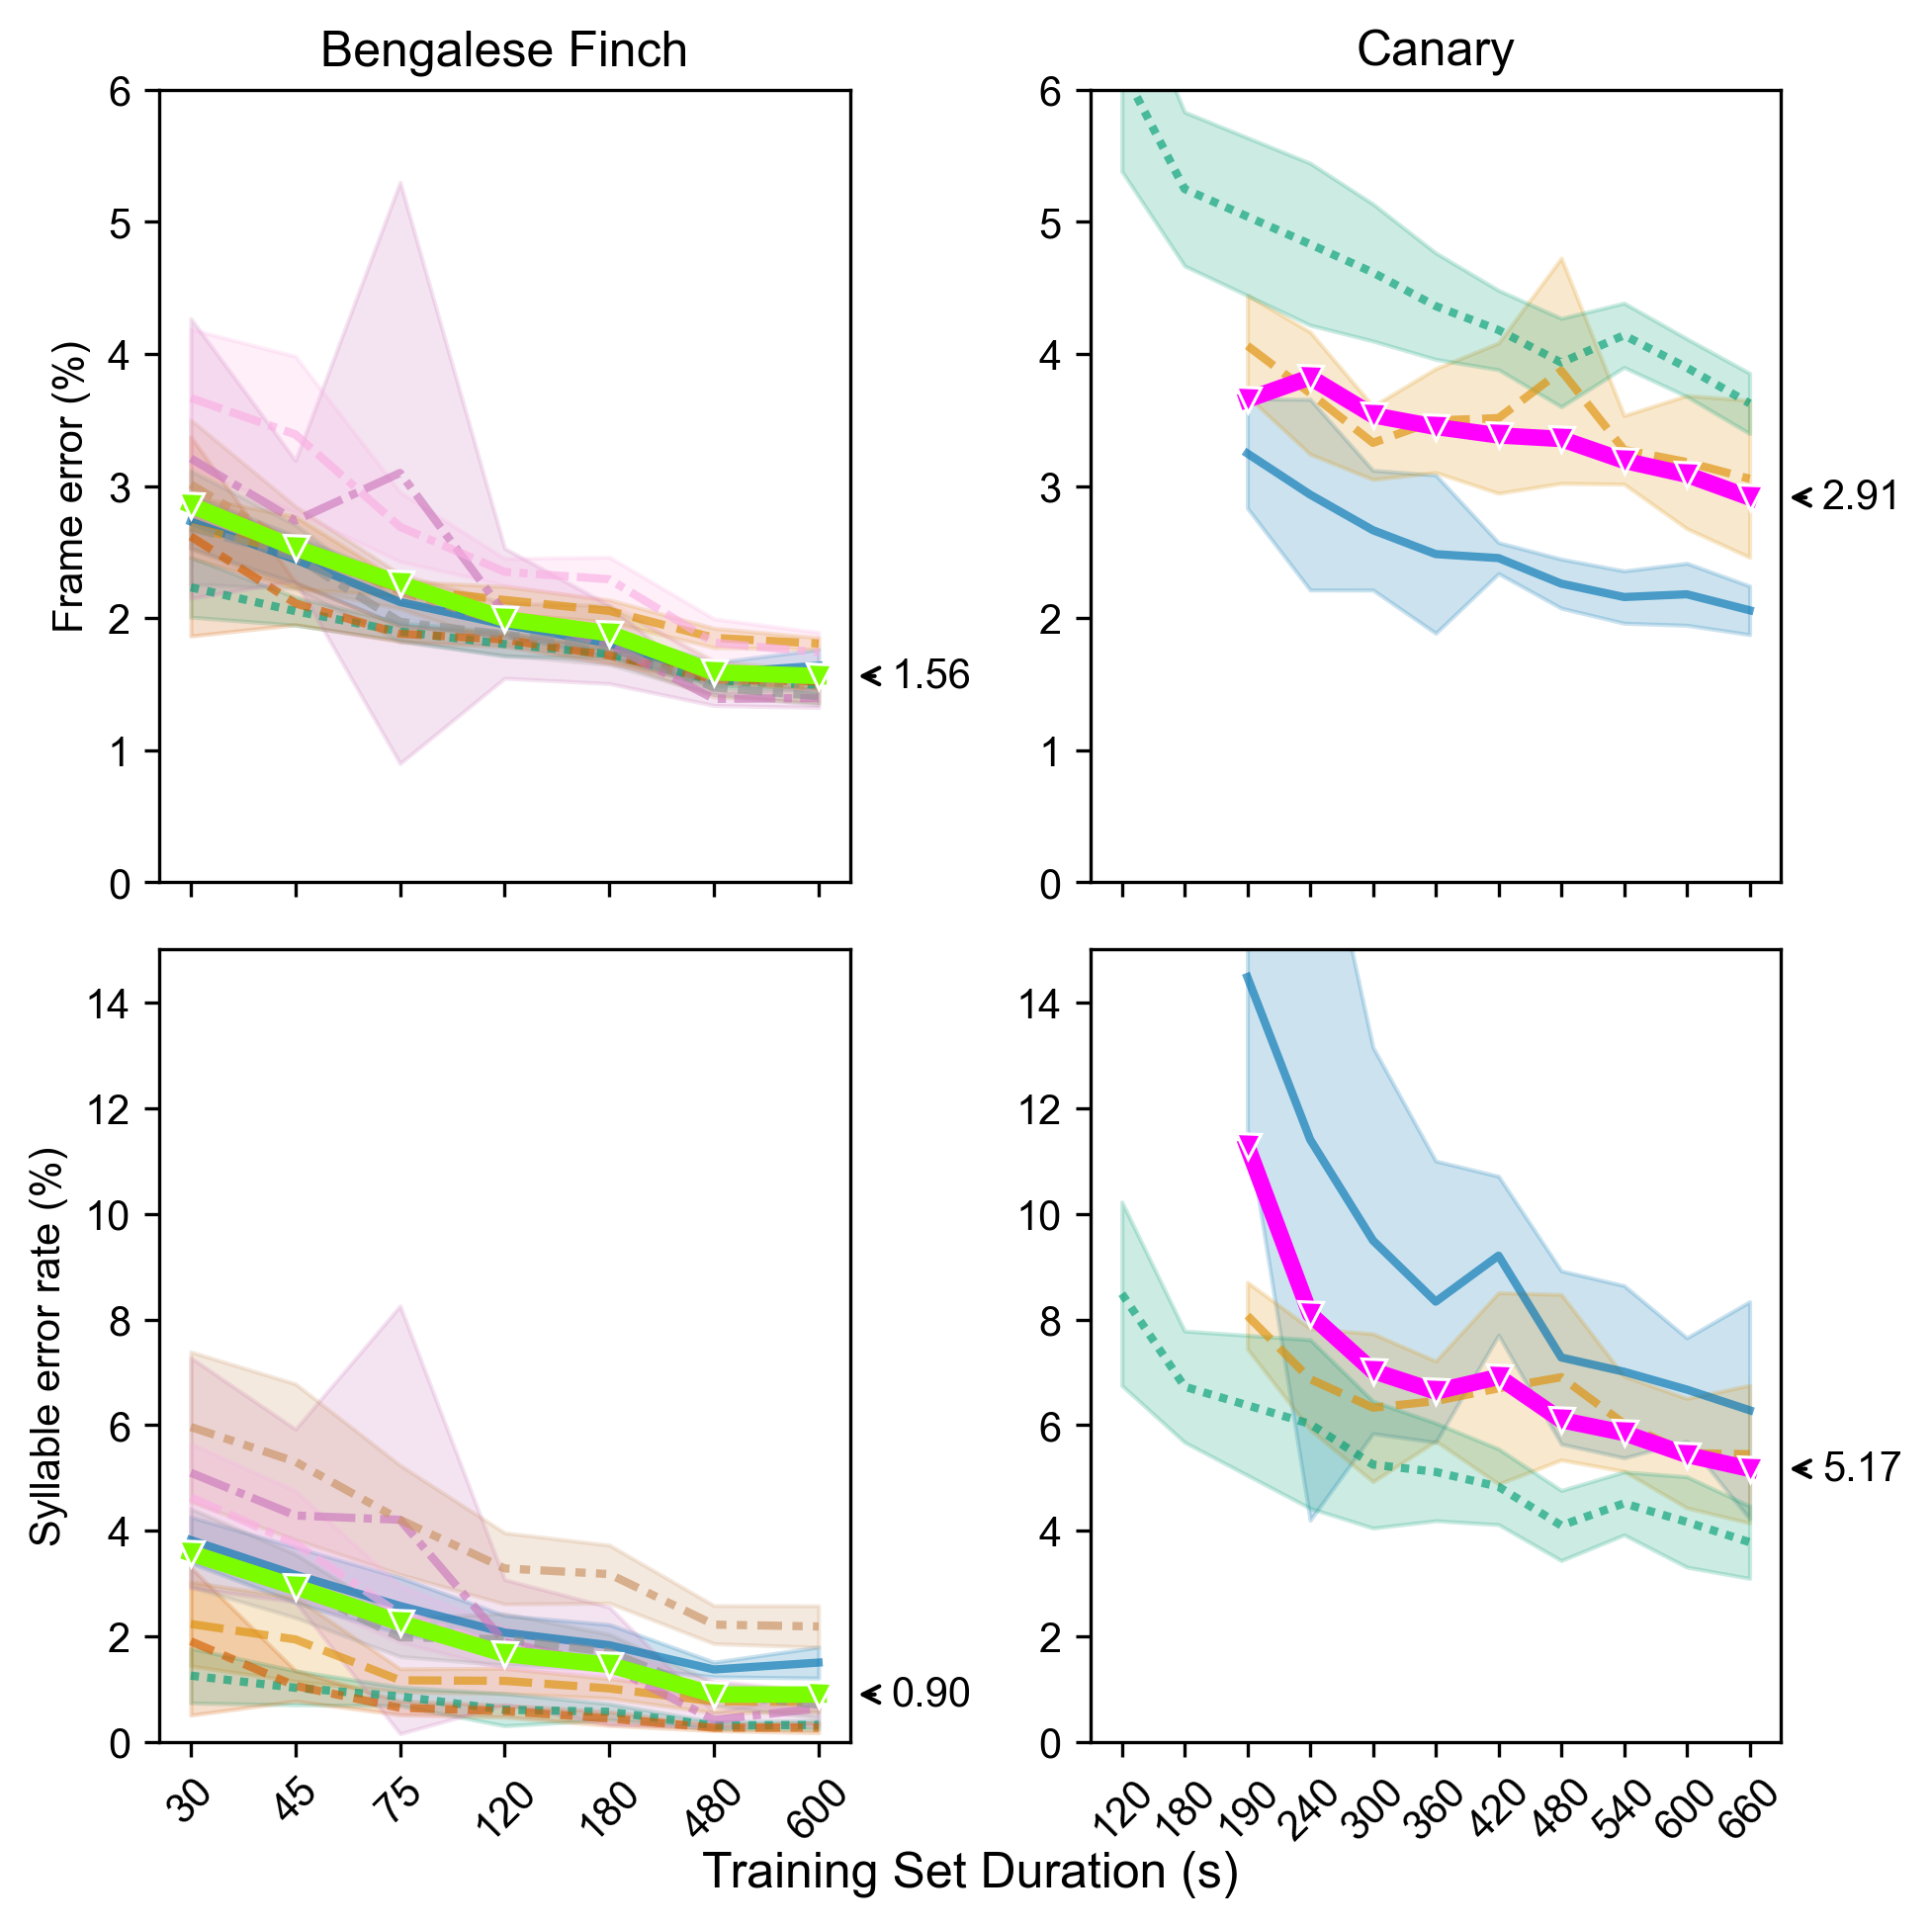

In [14]:
# make figure instance
FIGSIZE = (7, 7)
DPI = 300

NROWS = 2  # frame error rate, syllable error rate
NCOLS = 2  # Bengalese finches, Canaries

fig, ax_arr = plt.subplots(
    #constrained_layout=True,
    NROWS, NCOLS,
    figsize=FIGSIZE, 
    dpi=DPI
                )

# set up for loop
CLEANUP = 'min_segment_dur_majority_vote'

metrics = [
    'avg_error', 
    'avg_segment_error_rate',
]

cleanups = [
    CLEANUP,
    CLEANUP,
]

ylabels = [
    'Frame error (%)', 
    'Syllable error rate (%)', 
]

LEGEND = False

for col, (col_title, curve_df) in enumerate(
    zip(
        ['Bengalese Finch', 'Canary'],
        [bf_curve_df, canary_curve_df],
    )
):

    TRAIN_DUR_IND_MAP = {
        k:v for k, v in zip(
            sorted(curve_df['train_set_dur'].unique()), 
            sorted(curve_df['train_set_dur_ind'].unique())
        )
    }

    for metric, cleanup, ylabel in zip(metrics, cleanups, ylabels):
        if metric == 'avg_error':
            row = 0
        elif metric == 'avg_segment_error_rate':
            row = 1

        ax = ax_arr[row, col]

        curve_df_cleanup = curve_df[curve_df.cleanup == cleanup]
        if metric == 'avg_segment_error_rate' and cleanup == 'none':
            pass
        else:
            sns.lineplot(x='train_set_dur_ind', 
                         y=metric, 
                         hue='animal_id',
                         style='animal_id',
                         data=curve_df_cleanup,
                         ci='sd',
                         palette='colorblind',
                         linewidth=2, 
                         ax=ax, 
                         legend=LEGEND,
                         alpha=0.65)

        if col_title == 'Canary':
            # only plot mean for training set durations where we have results for all birds, which is > 180
            curve_df_for_mean = curve_df_cleanup[curve_df_cleanup.train_set_dur > 180]
        else:
            curve_df_for_mean = curve_df_cleanup

        color = SPECIES_PALETTE[col_title]

        if metric == 'avg_segment_error_rate' and cleanup == 'none':
            alpha = 0.65
        else:
            alpha = 1.0

        sns.lineplot(x='train_set_dur_ind',
                     y=metric, 
                     linestyle='solid', 
                     color=color, 
                     linewidth=4, 
                     data=curve_df_for_mean,
                     ci=None,
                     label='mean',
                     ax=ax,
                     marker='v',
                     alpha=alpha,
                     legend=LEGEND)
        mean_acc_max_dur = curve_df_for_mean[
            curve_df_for_mean.train_set_dur == curve_df_for_mean.train_set_dur.max()
        ][metric].mean()

        if col == 0:
            ylabel_text = ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
        ax.set_xlabel('')

        ax.set_xticks(list(TRAIN_DUR_IND_MAP.values()))
        if row == NROWS - 1:
            ax.set_xticklabels(sorted(curve_df['train_set_dur'].unique().astype(int)), rotation=45)
        else:
            ax.set_xticklabels([])

        ax.annotate(f'{mean_acc_max_dur:0.2f}',
                    xy=(ax.get_xlim()[-1], mean_acc_max_dur), 
                    xycoords='data',
                    xytext=(10, 0), 
                    textcoords='offset points',
                    verticalalignment='center',
                    arrowprops=dict(arrowstyle="->", facecolor='black'),
                    annotation_clip=False)

            
        if row == 0:
            title_text = ax.set_title(col_title)  # use Text instance below for 'big panel axis'

# zoom-in / limit the view to different portions of the data
for ax in ax_arr[0, :]:
    ax.set_ylim(0, 6)
for ax in ax_arr[1, :]:
    ax.set_ylim(0, 15)

# add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

# use Text instance from above so that this label is the same size as the axes titles
title_fontsize = title_text.get_size()
big_ax.set_xlabel("Training Set Duration (s)", labelpad=10, fontsize=title_fontsize);
       
fig.tight_layout()

for ext in ('svg', 'png'):
    fig.savefig(
        THIS_FIG_ROOT / f'error-curves-across-individuals-species.{ext}',
        bbox_inches='tight',
    )